# Google Drive Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


ITS Dataset-Generation

Clear Image Total = 1399
Hazy Image Total = 13990
Training =
Val/Test =
Val --> Clear Image = 99
Val --> Hazy Image = 990
Train --> Clear Image = 1300
Train --> Hazy Image = 13000


## Imports

In [2]:
!pip install -q tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
import os
import random
import sys
import time
import math
import torch
import torch.utils.data as data
import torchvision.transforms as tfs
from torchvision.transforms import functional as FF
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import h5py
import glob

from torch.backends import cudnn
from torch import optim
import torch, warnings
from torch import nn

import torch.nn.functional as F
from torch.nn import init
import functools

from torch.autograd import Variable
from torchvision import models

from torch.nn.modules import conv
from torch.nn.modules.utils import _pair
import warnings
warnings.filterwarnings('ignore')

## Utils

In [4]:
dataset_dir = '/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Winter 2023-24/EECS 6322/6322_Project_Folder/datasets'
data_dir = '/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Winter 2023-24/EECS 6322/6322_Project_Folder/data'
DH_dir = 'Dense_Haze'
ITS_dir = 'ITS'
SOTS_dir = 'SOTS'
NH_dir = 'NH_Haze'
base = '/content/drive/MyDrive/Academic/Course Work/Masters YorkU/Winter 2023-24/EECS 6322/6322_Project_Folder'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Load Dataset

```
Dense-Haze is the NTIRE2019 challenge dataset in the single image dehazing task, which consists of dense and
homogeneous hazy scenes. The hazy scenes have been recorded by introducing real haze generated by
professional haze machines. It consists of 45 training images, 5 validation images and 5 test images. As the
ground-truth test images are not public, we use validation images as test set in our work. NH-HAZE is
the NTIRE2020 challenge dataset in the single image dehazing task, which also consists of 45 training
images, 5 validation images and 5 test images. As both the ground-truth of validation images and test images
are not public, we divide training images into training set and test set which consist of 40 images and 5
images respectively. Different from other datasets, the hazy on NH-HAZE is nonhomogeneous. The sizes both in
Dense-Haze and Dense-Haze are 1,600×1,200.
```

### Dense-haze dataset

In [7]:
class DHAZE_Dataset(data.Dataset):
    def __init__(self, path, train, size, format='.png'):
        super(DHAZE_Dataset, self).__init__()
        self.size = size
        self.train = train
        self.hazy_path = path + '/hazy/'
        self.gt_path = path + '/gt/'
        self.format = format

    def __getitem__(self, index):
        index = index + 1
        # print(f"HAZY PATH: {self.hazy_path}")
        # print(f"GT PATH: {self.gt_path}")
        # print(f"FORMAT: {self.format}\n")
        hazy_filename = self.hazy_path + str(index) + '_hazy' + self.format
        # print(hazy_filename)
        gt_filename = self.gt_path + str(index) + '_GT' + self.format
        # print(gt_filename)

        hazy = Image.open(hazy_filename)
        gt = Image.open(gt_filename)

        gt = tfs.CenterCrop(hazy.size[::-1])(gt)

        if not isinstance(self.size, str):
            i, j, h, w = tfs.RandomCrop.get_params(hazy, output_size=(self.size, self.size))
            hazy = FF.crop(hazy, i, j, h, w)
            gt = FF.crop(gt, i, j, h, w)

        hazy, gt = self.augment_data(hazy.convert("RGB"), gt.convert("RGB"))

        return hazy, gt

    def augment_data(self, hazy, gt):

        if self.train:
            rand_hor = random.randint(0, 1)
            rand_rot = random.randint(0, 3)
            hazy = tfs.RandomHorizontalFlip(rand_hor)(hazy)
            gt = tfs.RandomHorizontalFlip(rand_hor)(gt)
            if rand_rot:
                hazy = FF.rotate(hazy, 90*rand_rot)
                gt = FF.rotate(gt, 90*rand_rot)

        hazy = tfs.ToTensor()(hazy)
        gt = tfs.ToTensor()(gt)

        return hazy, gt

    def __len__(self):
        train_list = glob.glob(self.hazy_path + '/*')

        return len(train_list)

# dataset=HAZE_Dataset(os.path.join(dataset_dir, DH_dir, 'Dense_train'), train=True,size=crop_size)
size = 224
batch_size = 16

DH_train_loader=DataLoader(dataset=DHAZE_Dataset(os.path.join(dataset_dir, DH_dir, 'Dense_train'), train=True,size=size), batch_size=batch_size, shuffle=True)
DH_test_loader=DataLoader(dataset=DHAZE_Dataset(os.path.join(dataset_dir, DH_dir, 'Dense_test'),train=False,size=size), batch_size=1, shuffle=False)

In [9]:
ds=DHAZE_Dataset(os.path.join(dataset_dir, DH_dir, 'Dense_test'), train=False, size=size)

In [10]:
def plot_sample(dataset, index=0):
    hazy, gt = dataset[index]

    hazy_img = hazy.numpy().transpose((1, 2, 0))
    gt_img = gt.numpy().transpose((1, 2, 0))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    ax1.imshow(hazy_img)
    ax1.set_title('Hazy Image')

    ax2.imshow(gt_img)
    ax2.set_title('GT Image')

    plt.tight_layout()
    plt.show()

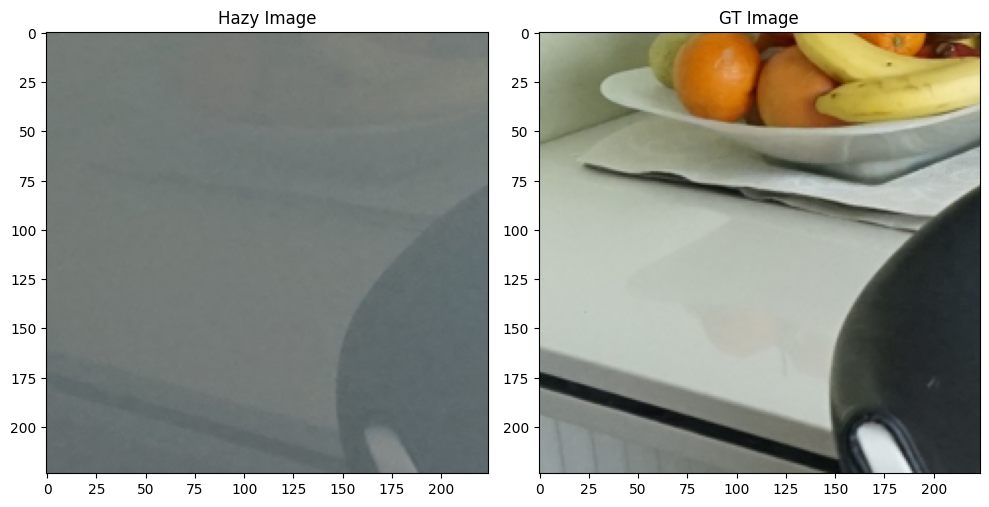

In [12]:
plot_sample(ds, index=3)

### ITS-dataset

In [13]:
class ITS_HAZE_Dataset(data.Dataset):
    def __init__(self, path, train, size, format='.png'):
        super(ITS_HAZE_Dataset, self).__init__()
        self.size = size
        self.train = train
        self.hazy_path = path + '/hazy/'
        self.gt_path = path + '/gt/'
        self.format = format
        self.gt_images = sorted(glob.glob(self.gt_path + '*' + self.format))
        self.num_hazy_per_gt = 10

    def __getitem__(self, index):
        gt_index = index // self.num_hazy_per_gt + 1  # Calculate ground truth index
        hazy_index = index % self.num_hazy_per_gt + 1  # Calculate specific hazy image index for the gt
        
        gt_filename = f"{self.gt_path}{gt_index}{self.format}"
        hazy_filename = f"{self.hazy_path}{gt_index}_{hazy_index}{self.format}"

        hazy = Image.open(hazy_filename)
        gt = Image.open(gt_filename)

        gt = tfs.CenterCrop(hazy.size[::-1])(gt)

        if not isinstance(self.size, str):
            i, j, h, w = tfs.RandomCrop.get_params(hazy, output_size=(self.size, self.size))
            hazy = FF.crop(hazy, i, j, h, w)
            gt = FF.crop(gt, i, j, h, w)

        hazy, gt = self.augData(hazy.convert("RGB"), gt.convert("RGB"))
        
        return hazy, gt

    def augment_data(self, hazy, gt):
        if self.train:
            rand_hor = random.randint(0, 1)
            rand_rot = random.randint(0, 3)
            hazy = tfs.RandomHorizontalFlip(rand_hor)(hazy)
            gt = tfs.RandomHorizontalFlip(rand_hor)(gt)
            if rand_rot:
                hazy = FF.rotate(hazy, 90*rand_rot)
                gt = FF.rotate(gt, 90*rand_rot)

        hazy = tfs.ToTensor()(hazy)
        gt = tfs.ToTensor()(gt)

        return hazy, gt

    def __len__(self):
        return len(self.gt_images) * self.num_hazy_per_gt


size = 224
batch_size = 16

ITS_train_loader=DataLoader(dataset=ITS_HAZE_Dataset(os.path.join(dataset_dir, ITS_dir, 'ITS_train'), train=True,size=size), batch_size=batch_size, shuffle=True)
ITS_test_loader=DataLoader(dataset=ITS_HAZE_Dataset(os.path.join(dataset_dir, ITS_dir, 'ITS_test'),train=False,size=size), batch_size=1, shuffle=False)

In [14]:
ds=ITS_HAZE_Dataset(os.path.join(dataset_dir, ITS_dir, 'ITS_train'), train=False, size=size)

In [15]:
def plot_sample(dataset, index=0):
    hazy, gt = dataset[index]

    hazy_img = hazy.numpy().transpose((1, 2, 0))
    gt_img = gt.numpy().transpose((1, 2, 0))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    ax1.imshow(hazy_img)
    ax1.set_title('Hazy Image')

    ax2.imshow(gt_img)
    ax2.set_title('GT Image')

    plt.tight_layout()
    plt.show()

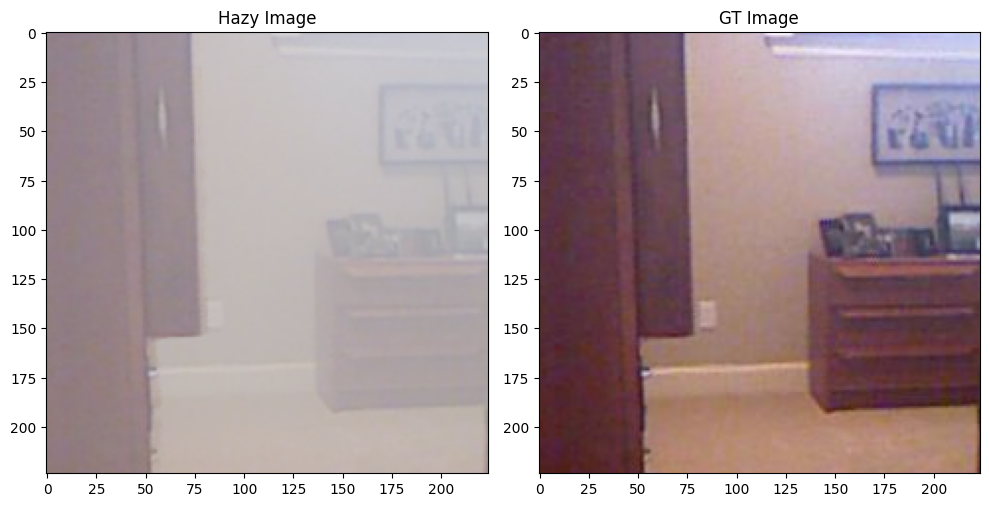

In [16]:
plot_sample(ds, index=3)

### NH-Haze

In [17]:
class NH_HAZE_Dataset(data.Dataset):
    def __init__(self, path, train, size=size, format='.png'):
        super(NH_HAZE_Dataset, self).__init__()
        self.size = size
        self.train = train
        self.hazy_path = path + '/hazy/'
        self.gt_path = path + '/gt/'
        self.format = format

    def __getitem__(self, index):
        index = index + 1
        # print(f"HAZY PATH: {self.hazy_path}")
        # print(f"GT PATH: {self.gt_path}")
        # print(f"FORMAT: {self.format}\n")
        hazy_filename = self.hazy_path + str(index) + '_hazy' + self.format
        # print(hazy_filename)
        gt_filename = self.gt_path + str(index) + '_GT' + self.format
        # print(gt_filename)

        hazy = Image.open(hazy_filename)
        gt = Image.open(gt_filename)

        gt = tfs.CenterCrop(hazy.size[::-1])(gt)

        if not isinstance(self.size, str):
            i, j, h, w = tfs.RandomCrop.get_params(hazy, output_size=(self.size, self.size))
            hazy = FF.crop(hazy, i, j, h, w)
            gt = FF.crop(gt, i, j, h, w)

        hazy, gt = self.augment_data(hazy.convert("RGB"), gt.convert("RGB"))

        return hazy, gt

    def augment_data(self, hazy, gt):

        if self.train:
            rand_hor = random.randint(0, 1)
            rand_rot = random.randint(0, 3)
            hazy = tfs.RandomHorizontalFlip(rand_hor)(hazy)
            gt = tfs.RandomHorizontalFlip(rand_hor)(gt)
            if rand_rot:
                hazy = FF.rotate(hazy, 90*rand_rot)
                gt = FF.rotate(gt, 90*rand_rot)

        hazy = tfs.ToTensor()(hazy)
        gt = tfs.ToTensor()(gt)

        return hazy, gt

    def __len__(self):
        train_list = glob.glob(self.hazy_path + '/*')

        return len(train_list)

size = 224
batch_size = 16

NH_train_loader=DataLoader(dataset=NH_HAZE_Dataset(os.path.join(dataset_dir, NH_dir, 'NH_train'), train=True,size=size), batch_size=batch_size, shuffle=True)
NH_test_loader=DataLoader(dataset=NH_HAZE_Dataset(os.path.join(dataset_dir, NH_dir, 'NH_test'),train=False,size=size), batch_size=1, shuffle=False)

In [18]:
ds=NH_HAZE_Dataset(os.path.join(dataset_dir, NH_dir, 'NH_train'), train=False, size=size)

In [19]:
def plot_sample(dataset, index=0):
    hazy, gt = dataset[index]

    hazy_img = hazy.numpy().transpose((1, 2, 0))
    gt_img = gt.numpy().transpose((1, 2, 0))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    ax1.imshow(hazy_img)
    ax1.set_title('Hazy Image')

    ax2.imshow(gt_img)
    ax2.set_title('GT Image')

    plt.tight_layout()
    plt.show()

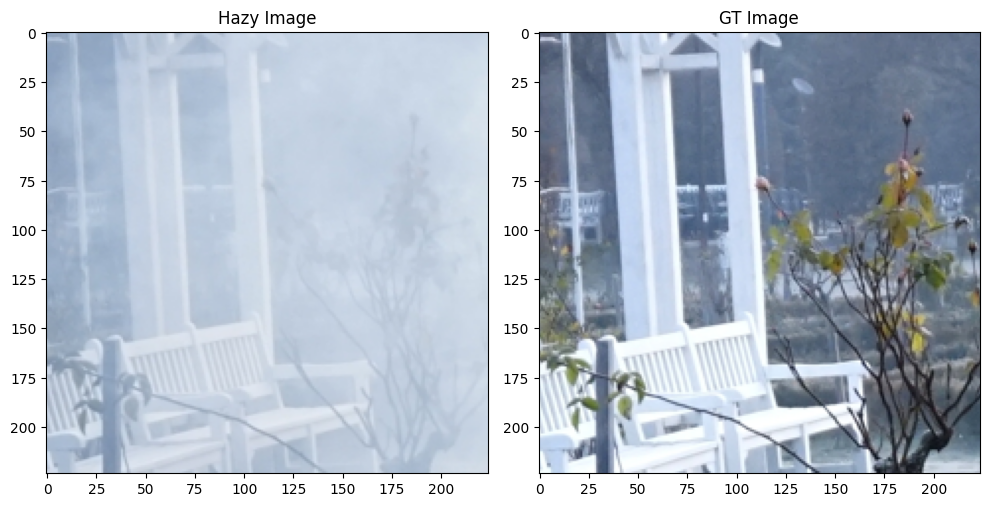

In [21]:
plot_sample(ds, index=3)